In [1]:
import tensorflow as tf
print("imported tensorflow")
import os
print("imported os")
import matplotlib
from matplotlib import pyplot as plt
import cv2
import imghdr
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

imported tensorflow
imported os


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

for gpu in gpus:
    gpu = tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
data = 'Dataset'
os.listdir(data)

image_exts = ['jpeg', 'jpg', 'bmp', 'png','JPEG','PNG','BMP'] 

In [5]:
for rock_type in os.listdir(data):
    rock_type_path = os.path.join(data, rock_type)
    
    # Skip if not a directory
    if not os.path.isdir(rock_type_path):
        continue
    
    # Loop through actual images in each rock type folder
    for image in os.listdir(rock_type_path):
        image_path = os.path.join(rock_type_path, image)
        
        # Skip if it's a directory (shouldn't be any)
        if os.path.isdir(image_path):
            continue
        
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {} - {}'.format(image_path, e))
            
print("Issues resolved")

Issues resolved


In [6]:
data = tf.keras.utils.image_dataset_from_directory('Dataset', shuffle = True) #ts is a pipeline
class_names = data.class_names

Found 1988 files belonging to 7 classes.


In [7]:
print(class_names)
#0-6

['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']


In [8]:
#normalizing the data...
data = data.map(lambda x,y: (x/255, y))

In [9]:
len(data)

63

In [10]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

print("Batches ->", train_size, val_size, test_size)
print("Total batches:", train_size + val_size + test_size)

Batches -> 44 9 10
Total batches: 63


In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(AUTOTUNE)
val = val.cache().prefetch(AUTOTUNE)
test = test.cache().prefetch(AUTOTUNE)

In [12]:
sample_batch = next(iter(train))
print("Min pixel value:", tf.reduce_min(sample_batch[0]).numpy())
print("Max pixel value:", tf.reduce_max(sample_batch[0]).numpy())
print("Sample pixel:", sample_batch[0][0][100][100].numpy())
print("Data type:", sample_batch[0].dtype)
print(f"Training batch labels: {sample_batch[1].numpy()}")
print(f"Unique labels: {set(sample_batch[1].numpy())}")
print(f"Class names: {class_names}")

Min pixel value: 0.0
Max pixel value: 1.0
Sample pixel: [0.34308147 0.34308147 0.34308147]
Data type: <dtype: 'float32'>
Training batch labels: [4 4 5 1 1 4 5 1 4 1 3 3 3 1 1 5 4 5 1 3 3 1 2 0 4 5 1 5 4 5 1 6]
Unique labels: {0, 1, 2, 3, 4, 5, 6}
Class names: ['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']


In [13]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Block 2
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# Block 4 (optional but highly recommended)
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

# Classifier
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                        

In [15]:
#Training...

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
44/44 [==============================] - 18s 231ms/step - loss: 8.3225 - accuracy: 0.3991 - val_loss: 6.7670 - val_accuracy: 0.2049
Epoch 2/20
44/44 [==============================] - 6s 134ms/step - loss: 2.2353 - accuracy: 0.4048 - val_loss: 12.6453 - val_accuracy: 0.1528
Epoch 3/20
44/44 [==============================] - 6s 134ms/step - loss: 1.7120 - accuracy: 0.4318 - val_loss: 18.5560 - val_accuracy: 0.1875
Epoch 4/20
44/44 [==============================] - 6s 134ms/step - loss: 1.7414 - accuracy: 0.4347 - val_loss: 9.0445 - val_accuracy: 0.2465
Epoch 5/20
44/44 [==============================] - 6s 135ms/step - loss: 1.6025 - accuracy: 0.4460 - val_loss: 5.7628 - val_accuracy: 0.1875
Epoch 6/20
44/44 [==============================] - 6s 136ms/step - loss: 1.5387 - accuracy: 0.4382 - val_loss: 5.0903 - val_accuracy: 0.2917
Epoch 7/20
44/44 [==============================] - 6s 136ms/step - loss: 1.5898 - accuracy: 0.4176 - val_loss: 6.8846 - val_accuracy: 0.2500
Epo

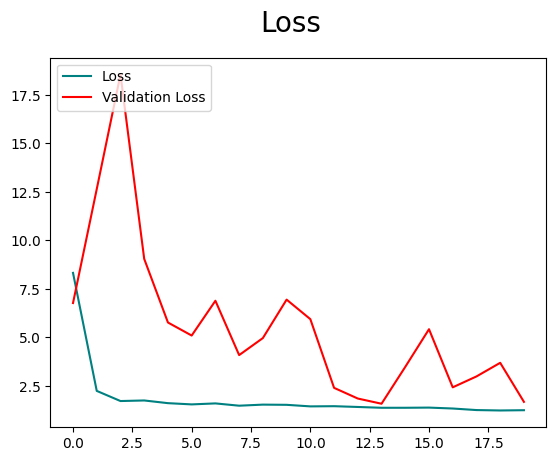

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'Loss')
plt.plot(hist.history['val_loss'], color = 'red', label = 'Validation Loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

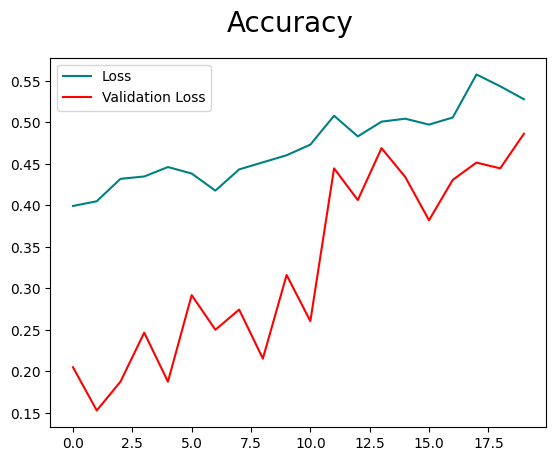

In [17]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'Loss')
plt.plot(hist.history['val_accuracy'], color = 'red', label = 'Validation Loss')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()